In [1]:
import numpy as np
import time
import generalized_genSim_shorten_time_HMM as ggsdHMM
import numpy as np
import curve_fitting as cf
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm as cmx
from scipy import optimize, stats
import bluepyopt as bpop
import bluepyopt.deapext.algorithms as algo
import vclamp_evaluator_HMMtoHH as vcl_ev
# import vclamp_evaluator_HMM as vcl_ev
import pickle
import time
from deap import tools
#from deap import base, creator
import multiprocessing
#import eval_helper as eh
#import scoring_functions_relative as sf
#import curve_fitting as cf
# import generalized_genSim_shorten_time as ggsd
# import eval_helper_na12mut8st as ehn
# import general_plotter

In [7]:
import sys
sys.executable

'/usr/common/software/python/3.7-anaconda-2019.07/bin/python3'

In [11]:
import deap

ModuleNotFoundError: No module named 'deap'

In [3]:
import numpy

In [4]:
import matplotlib.pyplot as plt

In [3]:
import neuron

ModuleNotFoundError: No module named 'neuron'

In [2]:
neuron.__version__

'8.0.2'

In [2]:
evaluator = vcl_ev.Vclamp_evaluator_HMM('./csv_files/params_na12mut8st_mod.csv', 'Basis', 'na12mut8st', 'na16', objective_names=['inact', 'act'])

# evaluator = vcl_ev.Vclamp_evaluator_HMM('./csv_files/params_na12mut8st.csv', 'A427D', 'na12mut8st', objective_names=['inact', 'act', 'recov'])


#evaluator = vcl_ev.Vclamp_evaluator_HMM('./param_stats_narrow.csv', 'A427D', 'na', objective_names=['v_half_act', 'gv_slope', 'v_half_ssi', 'ssi_slope'])

Couldn't fit curve to recovery.
{'v_half_act': -25.372778267834292, 'gv_slope': 5.979533066081991, 'v_half_ssi': -54.77535847253028, 'ssi_slope': 7.039069712260356, 'tau_fast': 0.001, 'tau_slow': 0.001, 'percent_fast': 1000}


In [3]:
initial_params_list = [
    4.584982656184167e+01,
    2.393541665657613e-02,
    1.440952344322651e-02,
    8.847609128769419e-02,
    1.980838207143563e+01,
    2.217709530008501e-02,
    5.650174488683913e-01,
    6.108403283302217e-02,
    7.181189201089192e+01,
    6.593790601261940e-02,
    7.531178253431512e-01,
    3.647978133116471e-02,
    2.830146966213825e+00,
    2.890045633775495e-01,
    6.960300544163878e-02,
    5.757824421450554e-01,
    1.628407420157048e+02,
    2.680107016756367e-02,
    10,
    10,
    8000
]
zeroed_params_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16.740391631625133, 19.134382730889705, 8000]

In [4]:
evaluator.evaluate_with_lists([101.0014648526637, 0.8862734717269865, 0.15635827755088857, 2.656173663016387, 1399.4237749791164, 1.0785461972588348, 20.077232019986212, 2.9743535819198614, 17.900874891193894, 0.13657027529172208, 27.631403243011864, 0.5531069464046251, 122.0626122531615, 10.336985429858657, 0.3897478732638633, 0.8153664290113486, 3121.469563474261, 1.650381448269692, 3.6589206782029784, 19.112488272685592, 18.04504138714])

([101.0014648526637, 0.8862734717269865, 0.15635827755088857, 2.656173663016387, 1399.4237749791164, 1.0785461972588348, 20.077232019986212, 2.9743535819198614, 17.900874891193894, 0.13657027529172208, 27.631403243011864, 0.5531069464046251, 122.0626122531615, 10.336985429858657, 0.3897478732638633, 0.8153664290113486, 3121.469563474261, 1.650381448269692, 3.6589206782029784, 19.112488272685592, 18.04504138714], [22.1078743859933])


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[22.1078743859933]

In [7]:
evaluator.evaluate_with_lists(initial_params_list)

[0.31967379065578244, 0.04146462549630251]

In [8]:
evaluator.evaluate_with_lists([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 8000])

Couldn't fit curve to activation.


[3.71729251645159, 39967145.71176991]

In [24]:
evaluator.evaluate_with_lists(zeroed_params_list)

[0.4290671503572307]

In [10]:
evaluator.wild_data

{'v_half_act': -25.372778269313965,
 'gv_slope': 5.979533056640875,
 'v_half_ssi': -54.77535847253028,
 'ssi_slope': 7.039069712260356,
 'tau_fast': 0.001,
 'tau_slow': 0.001,
 'percent_fast': 1000}

In [11]:
gen_counter = 0
best_indvs = []
cp_freq = 1
old_update = algo._update_history_and_hof
def my_update(halloffame, history, population):
    global gen_counter,cp_freq
    if halloffame is not None:
        halloffame.update(population)
    
    if halloffame:
        best_indvs.append(halloffame[0])
    gen_counter = gen_counter+1
    print("Current generation: ", gen_counter)
    if gen_counter%cp_freq == 0:
        fn = '.pkl'
        save_logs(fn,best_indvs,population)

def my_record_stats(stats, logbook, gen, population, invalid_count):
    '''Update the statistics with the new population'''
    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=gen, nevals=invalid_count, **record)
    print('log: \n', logbook, '\n')
    output = open("log.pkl", 'wb')
    pickle.dump(logbook, output)
    output.close()

def save_logs(fn, best_indvs, hof):
    output = open("indv"+fn, 'wb')
    pickle.dump(best_indvs, output)
    output.close()
    output = open("hof"+fn, 'wb')
    pickle.dump(hof, output)



In [12]:
#hof = tools.HallOfFame(1, similar=np.array_equal)
hof = tools.ParetoFront()
algo._update_history_and_hof = my_update
algo._record_stats = my_record_stats
pool = multiprocessing.Pool(processes=64)
deap_opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=500, hof = hof, map_function=pool.map)  # CHANGE offspring_size

cp_file = './cp.pkl'

/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.a

Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.

Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/u1/m/mikelam/SimulatingVariants/generalized_genSim_shorten_time_HMM.py:528: RuntimeWarning: invalid value encountered in true_divide
  self.inorm_vec = np.array(self.ipeak_vec) / ipeak_min


Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.


/global/homes/m/mikelam/.local/cori/3.7-anaconda-2019.07/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Couldn't fit curve to inactivation.
Couldn't fit curve to inactivation.
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivation data
Couldn't generate inactivati

In [13]:
start_time = time.time()
pop, hof, log, hst = deap_opt.run(max_ngen=100, cp_filename=cp_file)  # CHANGE max_ngen
end_time = time.time()
print(end_time - start_time)

Current generation:  1
log: 
 gen	nevals	avg        	std        	min     	max        
1  	500   	3.59706e+06	1.14379e+07	0.246513	3.99672e+07 

Current generation:  2
log: 
 gen	nevals	avg        	std        	min     	max        
1  	500   	3.59706e+06	1.14379e+07	0.246513	3.99672e+07
2  	500   	3.31729e+06	1.10262e+07	0.203494	3.99672e+07 

Current generation:  3
log: 
 gen	nevals	avg        	std        	min     	max        
1  	500   	3.59706e+06	1.14379e+07	0.246513	3.99672e+07
2  	500   	3.31729e+06	1.10262e+07	0.203494	3.99672e+07
3  	500   	279781     	3.33217e+06	0.129243	3.99672e+07 

Current generation:  4
log: 
 gen	nevals	avg        	std        	min      	max        
1  	500   	3.59706e+06	1.14379e+07	0.246513 	3.99672e+07
2  	500   	3.31729e+06	1.10262e+07	0.203494 	3.99672e+07
3  	500   	279781     	3.33217e+06	0.129243 	3.99672e+07
4  	500   	319743     	3.56045e+06	0.0738593	3.99672e+07 

Current generation:  5
log: 
 gen	nevals	avg        	std        	min      	max     

KeyboardInterrupt: 

In [7]:
print(log)

gen	nevals	avg     	std	min     	max     
1  	10    	0.188278	0  	0.188278	0.188278
2  	10    	0.188278	0  	0.188278	0.188278
3  	10    	0.188278	0  	0.188278	0.188278
4  	10    	0.188278	0  	0.188278	0.188278
5  	10    	0.188278	0  	0.188278	0.188278
6  	10    	0.188278	0  	0.188278	0.188278
7  	10    	0.188278	0  	0.188278	0.188278
8  	10    	0.188278	0  	0.188278	0.188278
9  	10    	0.188278	0  	0.188278	0.188278
10 	10    	0.188278	0  	0.188278	0.188278


In [9]:
evaluator.evaluate_with_lists(best_indvs[-1])

[0.18827824826883705]

In [12]:
evaluator.evaluate_with_lists([5.530342100682532, 0.9008039775344863, 0.24858223561941958, 1.7268438160041637, 1270.3580622487675, 0.06568081796710751, 7.981138723890824, 3.700474349232621, 117.62676107332793, 1.4413613544750017, 9.903914417649071, 0.24062486851875498, 48.14278569436884, 12.749323014147233, 0.8372883639503781, 0.10390434773339315, 2316.985818952397, 1.7873519280436765, -18.912553479744098, 6.388939651755274, 490095.60510189296])

[0.05230471742503818]

In [ ]:
import eval_helper as eh
eh.change_params(best_indvs[-1], scaled=False, is_HMM=True)

In [ ]:
ehn.find_tau0(make_plot=True)

In [3]:
best_params = [56.81345170647479, 2.048868220552543, 0.08659172088859458, 1.0259026838639276, 821.2120665082857, 0.6893081442865512, 21.317221488747638, 0.15527899460547995, 385.78026002963486, 1.839603301537428, 1.016931529353478, 0.45162680599095495, 16.015502290391144, 6.951531579838077, 0.23300876712126936, 0.4665767493851326, 2815.7056551386886, 0.5693383614316656, 15.942798606178815, -7.22819922086931, 42155.85611437511]
evaluator.evaluate_with_lists(best_params)

/Users/workbench/SimulatingVariants/curve_fitting.py:19: RuntimeWarning: overflow encountered in exp
  return bottom +  ((top - bottom) / (1.0 + np.exp((v_half - x)/slope)))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[24.023322425324377, 7.722171644843661e-06]

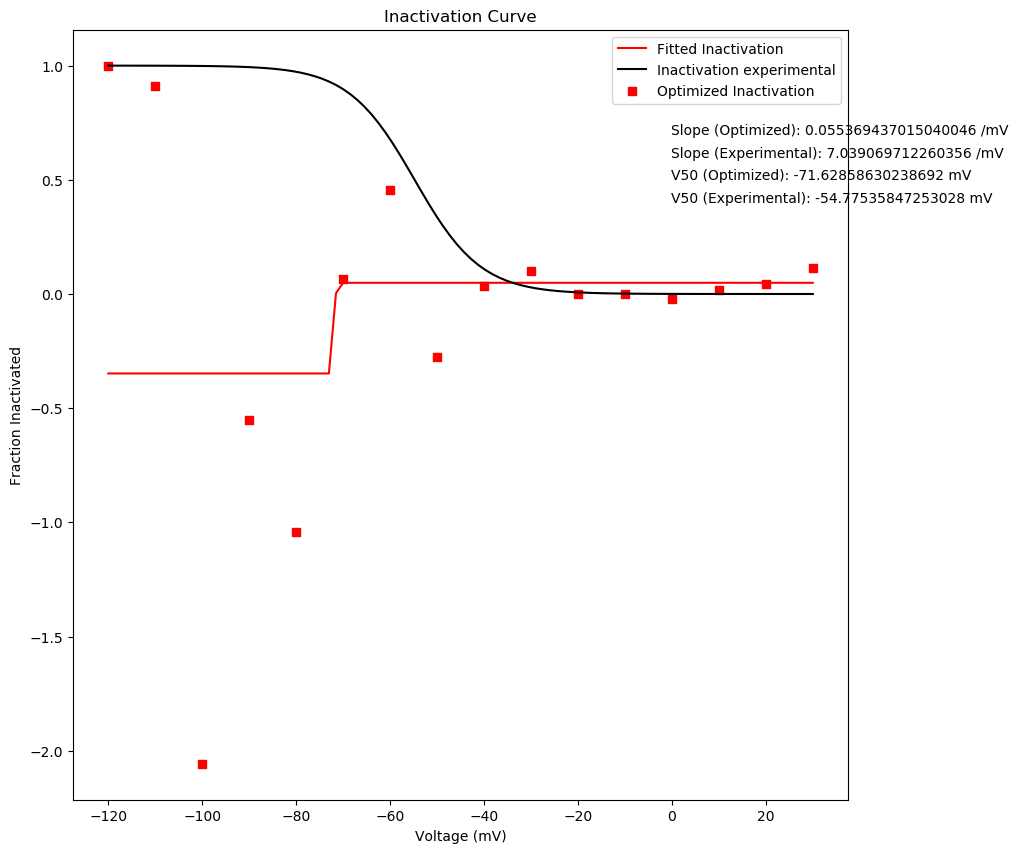

In [4]:
evaluator.plot_inact(best_params)

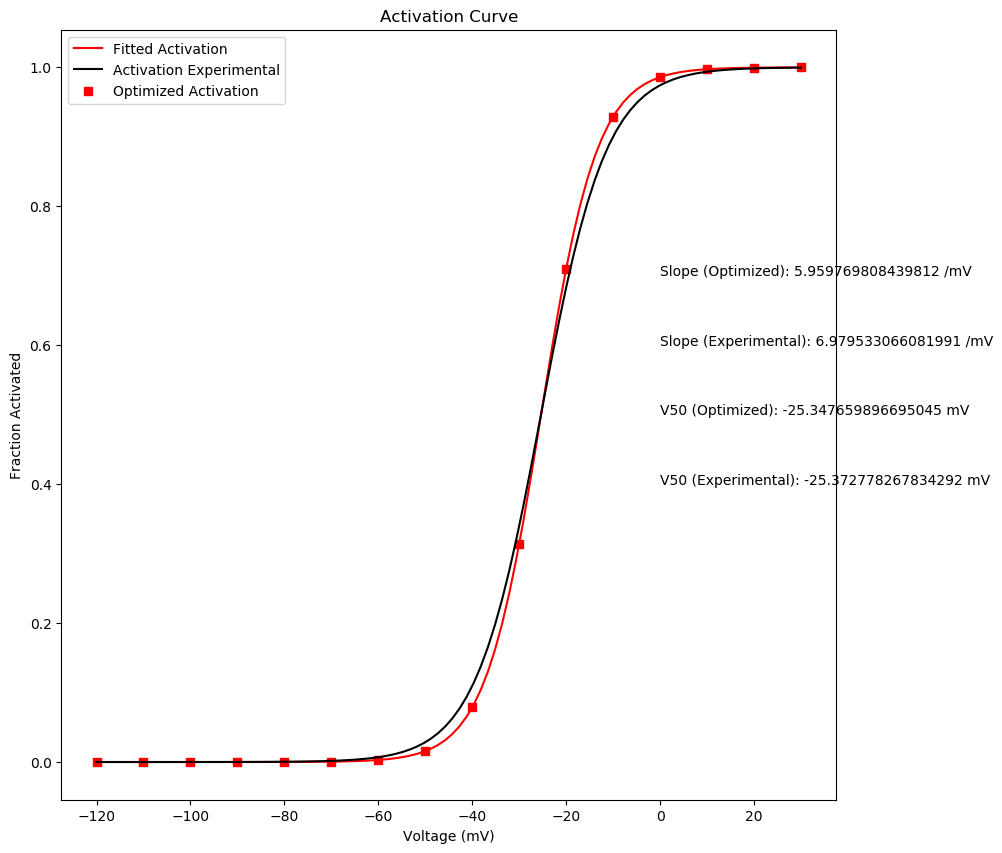

In [5]:
evaluator.plot_act(best_params)

In [ ]:
evaluator.plot_inact(best_indvs[-1])

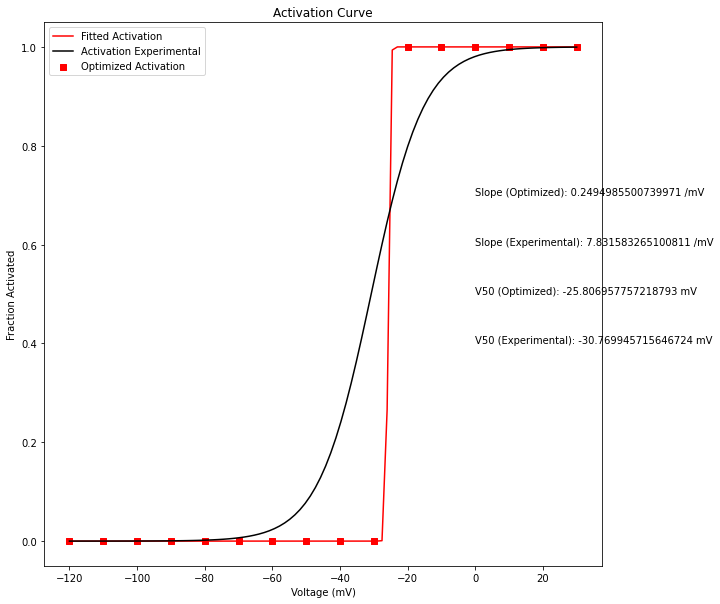

In [11]:
evaluator.plot_act(best_indvs[-2])

In [12]:
best_indvs

[[19.325933626476957,
  0.7895218087251863,
  0.25472935302161714,
  3.694845290002194,
  1679.8218545477334,
  0.8778186352079245,
  41.818183263756275,
  4.049203451143561,
  141.43014280192034,
  1.5231970816465987,
  34.567375532101714,
  0.4768247096185041,
  104.27782194252745,
  15.340379164998039,
  0.09638789764876615,
  0.40238557121654156,
  2540.4755792606097,
  0.8972905308464995,
  -11.692320034882627,
  6.046882127518444,
  562434.9853264086],
 [19.325933626476957,
  0.7895218087251863,
  0.25472935302161714,
  3.694845290002194,
  1679.8218545477334,
  0.8778186352079245,
  41.818183263756275,
  4.049203451143561,
  141.43014280192034,
  1.5231970816465987,
  34.567375532101714,
  0.4768247096185041,
  104.27782194252745,
  15.340379164998039,
  0.09638789764876615,
  0.40238557121654156,
  2540.4755792606097,
  0.8972905308464995,
  -11.692320034882627,
  6.046882127518444,
  562434.9853264086],
 [134.2559475545607,
  0.7901342674805327,
  0.19701974425718285,
  3.6847

In [ ]:
best_indvs[-1]

In [ ]:
import eval_helper_na12mut as ehn
import eval_helper_na12mut8st as ehn8

In [ ]:
ehn.find_time_to_peak()

In [ ]:
ehn8.find_time_to_peak()

In [ ]:
na12mut_params = [8, -30, 7.2, 0.4, 0.124, -45, -45, 0.5, 1.5, 0.02, 0.01, 2, 0.01, .03, -45, 7, -60, 0.0003, 12, 0.2, 10, -58, 2, 55]

In [ ]:
opt_HMM_params = [7.469160595102233, 0.1110309461516207, 0.09834011757279898, 1.959729160651832, 1491.0890579477725, 0.9777458769346035, 45.97790651811909, 4.882721940602804, 242.65899105292436, 2.5542201851262116, 3.09332385731855, 0.3596166292564826, 175.64752705910956, 13.719069975558211, 1.4023566772303253, 0.14909624523920945, 2158.0900150490675, 0.4841273939654566, 21.95876324483144, 16.98204089057011]

In [ ]:
general_plotter.plot_act(na12mut_params, 'na12mut', False, opt_HMM_params, 'na12mut8st', True, './test.pdf', 'na12mut')